In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health-and-burnout-in-the-workplace/mental_health_workplace_survey.csv


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns

sns.set_style("whitegrid")



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
file_path = "/kaggle/input/mental-health-and-burnout-in-the-workplace/mental_health_workplace_survey.csv"
df = pd.read_csv(file_path)

In [27]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()


df.replace(['', 'na', 'n/a', 'none', 'unknown'], np.nan, inplace=True)

print("\nMissing values per column:\n")
print(df.isna().sum())


numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Filled missing in {col} with median = {median_val}")


cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)
    print(f"Filled missing in {col} with mode = '{mode_val}'")


Missing values per column:

EmployeeID                0
Age                       0
Gender                    0
Country                   0
JobRole                   0
Department                0
YearsAtCompany            0
WorkHoursPerWeek          0
RemoteWork                0
BurnoutLevel              0
JobSatisfaction           0
StressLevel               0
ProductivityScore         0
SleepHours                0
PhysicalActivityHrs       0
CommuteTime               0
HasMentalHealthSupport    0
ManagerSupportScore       0
HasTherapyAccess          0
MentalHealthDaysOff       0
SalaryRange               0
WorkLifeBalanceScore      0
TeamSize                  0
CareerGrowthScore         0
BurnoutRisk               0
dtype: int64
Filled missing in EmployeeID with median = 2500.5
Filled missing in Age with median = 41.0
Filled missing in YearsAtCompany with median = 10.0
Filled missing in WorkHoursPerWeek with median = 45.0
Filled missing in BurnoutLevel with median = 5.48
Filled miss

In [30]:
y = df["BurnoutRisk"]
# Define features (drop target and ID)
X = df.drop(columns=["BurnoutRisk", "EmployeeID"], errors='ignore')


categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])


# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=69, test_size=0.2)

# Model Training 

# Logistic Regression 
pipeline_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=69))
])
pipeline_lr.fit(X_train, y_train)

# LDA 
pipeline_lda = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LinearDiscriminantAnalysis())
])
pipeline_lda.fit(X_train, y_train)

#Evaluate
y_pred_lr = pipeline_lr.predict(X_test)
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]
y_pred_lda = pipeline_lda.predict(X_test)
y_prob_lda = pipeline_lda.predict_proba(X_test)[:, 1]

def evaluate_model(name, y_test, y_pred, y_prob):
    print(f"\n--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_model("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
evaluate_model("LDA", y_test, y_pred_lda, y_prob_lda)



--- Logistic Regression ---
Accuracy: 0.9883
ROC-AUC: 0.9996
Confusion Matrix:
 [[402   2]
 [  5 191]]

--- LDA ---
Accuracy: 0.9650
ROC-AUC: 0.9980
Confusion Matrix:
 [[383  21]
 [  0 196]]


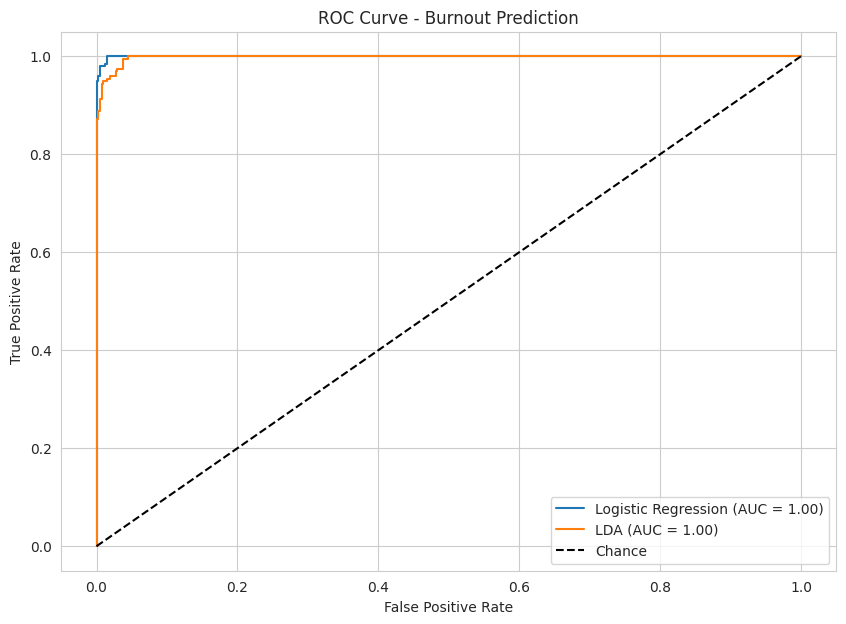

In [31]:

#GRaph

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda)
auc_lr = roc_auc_score(y_test, y_prob_lr)
auc_lda = roc_auc_score(y_test, y_prob_lda)

# Ploting ROC 
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_lda, tpr_lda, label=f"LDA (AUC = {auc_lda:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Burnout Prediction")
plt.legend()
plt.grid(True)
plt.show()